# Restaurant Recommendation System

## 3. Modelling


## Aim
After getting a sense of data from EDA, now we will now write our recommendation system. We will use Collaborative Filtering to recommend. We create embeddings for every user and every restaurant, every number in a L-dimensional embedding describes some property of user or restaurant. 
To learn these embeddings we use a neural network which minimizes MSE on train set. Train set consists of user id and business id as input variables and rating given as target variable. We'll also write another and compare performance.


### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import json
from sqlite3 import dbapi2 as sq3
from pathlib import Path
from collections import OrderedDict

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Activation
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Embedding, Add, Dot, Flatten,Concatenate, Dense
from tensorflow.keras import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import plot_model
from sklearn.metrics import mean_squared_error as mse


from time import time
from IPython.display import clear_output

In [2]:
# Connect to sqlite db
db = sq3.connect('../input/yelp-project/yelp_database.db')

In [3]:
# Functions to work with SQLite db
def make_query(sel):
    c = db.cursor().execute(sel)
    return c.fetchall()

def make_frame(list_of_tuples, legend):
    framelist=[]
    for i, cname in enumerate(legend):
        framelist.append((cname,[e[i] for e in list_of_tuples]))
    return pd.DataFrame.from_dict(OrderedDict(framelist))

In [4]:
%%time

#Getting data to feed to model
q = make_query("SELECT user_id, business_id, stars FROM reviews")
ratings_df = make_frame(q, legend=['user_id', 'business_id', 'stars'])
del q
ratings_df.head()

CPU times: user 18.7 s, sys: 4.41 s, total: 23.1 s
Wall time: 1min 28s


,user_id,business_id,stars
0,68678,7124,5.0
1,44092,952,1.0
2,84023,2916,4.0
3,48318,4641,5.0
4,84754,2120,5.0


In [5]:
ratings_df.shape

(5509524, 3)

### Recommendation using Collaborative Filtering with Matrix Factorization

Splitting Data

In [6]:
#Train - Val - Test
#80% - 10% - 10%
X_train, X, y_train, y = train_test_split(ratings_df.drop('stars', axis=1), ratings_df.stars, train_size=.8)
X_test, X_val, y_test, y_val = train_test_split(X, y, train_size=.5)
del X, y

print(f"Train Size: {round(X_train.shape[0]/ratings_df.shape[0]*100)}%")
print("X train shape: ", X_train.shape)
print("y train shape: ", y_train.shape)

print(f"\nValidation Size: {round(X_val.shape[0]/ratings_df.shape[0]*100)}%")
print("X val   shape: ", X_val.shape)
print("y val   shape: ", y_val.shape)

print(f"\nTest Size: {round(X_test.shape[0]/ratings_df.shape[0]*100)}%")
print("X test  shape: ", X_test.shape)
print("y test  shape: ", y_test.shape)

Train Size: 80%
X train shape:  (4407619, 2)
y train shape:  (4407619,)

Validation Size: 10%
X val   shape:  (550953, 2)
y val   shape:  (550953,)

Test Size: 10%
X test  shape:  (550952, 2)
y test  shape:  (550952,)


In [7]:
# Helper functions 
def create_bias(name, inp, n_in, reg):
    #x = Embedding(n_in, 1, input_length=1, embeddings_regularizer=l2(reg))(inp)
    x = Embedding(n_in, 1, input_length=1, name=name)(inp)
    return Flatten(name=name+'_flat')(x)
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, name=name.split('_')[0]+'_factor', embeddings_regularizer=l2(reg))(inp)

def sigmoid_maker(low, high):
    def custom_sigmoid(x):
        return K.sigmoid(x)*(high - low) + low #within range
    return custom_sigmoid

In [8]:
# Getting total unique restaurants and user in data
nrestaurants = make_query("SELECT COUNT(*) FROM businesses")[0][0]
nusers = make_query("SELECT COUNT(*) FROM users")[0][0]
print("Number of Restaurants:", nrestaurants)
print("Number of Users:", nusers)

Number of Restaurants: 80505
Number of Users: 1968703


### Average Baseline Accuracy
Average model always predict average of all the ratings. This gives us a number which we'll try to improve on.

In [13]:
#Baseline accuracy
mean_rating = y_train.mean()

train_baseline = mse(y_train, [mean_rating]*y_train.shape[0])
val_baseline = mse(y_val, [mean_rating]*y_val.shape[0])
test_baseline = mse(y_test, [mean_rating]*y_test.shape[0])


print(f"""Baseline MSE using mean rating:\n
          Train Data: {train_baseline:.4f},
          Val   Data: {val_baseline:.4f},
          Test  Data: {test_baseline:.4f}""")

Baseline MSE using mean rating:

          Train Data: 1.9476,
          Val   Data: 1.9520,
          Test  Data: 1.9556


### Linear Recommendation System
Here we use dot product of embeddings and add user and restaurant bias before putting through sigmoid.

In [14]:
L = 50
REG = 1e-2

user_input, uLmat = embedding_input('user_input', nusers, L, REG)
restaurant_input, mLmat = embedding_input('restaurant_input', nrestaurants, L, REG)
user_bias = create_bias('user_bias', user_input, nusers, REG)
restaurant_bias = create_bias('restaurant_bias', restaurant_input, nrestaurants, REG)

residual = Dot(axes=2, name="residual")([uLmat, mLmat])
residflat = Flatten(name="residual_flat")(residual)
regression = Add(name="regression")([user_bias, restaurant_bias, residflat])

cs = sigmoid_maker(0, 5.5)
output = Activation(cs, name="Sigmoid_Range")(regression)
model = Model([user_input, restaurant_input], output)
model.compile(Adam(.01), loss='mse')

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
restaurant_input (InputLayer)   [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_factor (Embedding)         (None, 1, 50)        98435150    user_input[0][0]                 
__________________________________________________________________________________________________
restaurant_factor (Embedding)   (None, 1, 50)        4025250     restaurant_input[0][0]           
____________________________________________________________________________________________

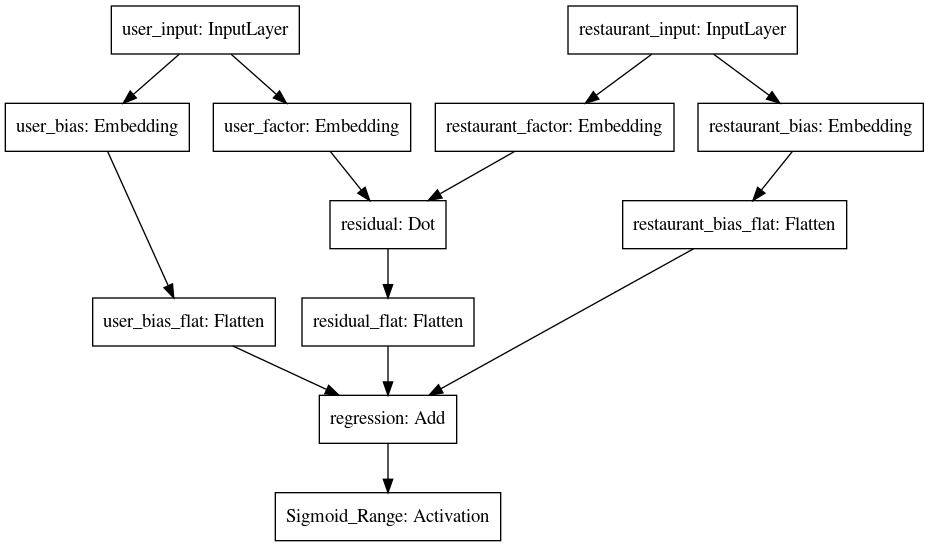

In [15]:
plot_model(model)

In [16]:
#Training Model
model.optimizer.learning_rate = 5e-2
h1 = model.fit([X_train.user_id, X_train.business_id], y_train, epochs=2, 
              validation_data=([X_val.user_id, X_val.business_id], y_val), batch_size=1024, verbose=1)

# model.optimizer.learning_rate = 5e-3
# h2 = model.fit([X_train.user_id, X_train.business_id], y_train, epochs=1, 
#               validation_data=([X_val.user_id, X_val.business_id], y_val), batch_size=512, verbose=2)

Epoch 1/2
4305/4305 [==============================] - 3932s 913ms/step - loss: 12.8256 - val_loss: 5.1694
Epoch 2/2
4305/4305 [==============================] - 3905s 907ms/step - loss: 3.7988 - val_loss: 4.5063


Text(0.5, 1.0, 'Loss Plot')

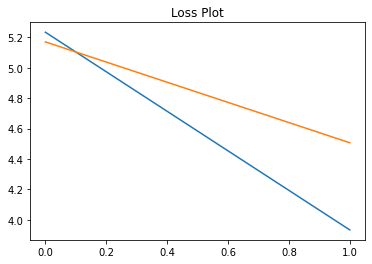

In [17]:
# Plotting Train and Val loss

loss = h1.history['loss']#+h2.history['loss']
val_loss = h1.history['val_loss']#+h2.history['val_loss']
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.title('Loss Plot')

In [18]:
#Saving model
model.save('Linear_Model')

### Non-Linear Recommendation System 
Here we use non-linear combination of embeddings by stacking them together and passing through FFNN  and then add user and restaurant bias before putting through sigmoid.

In [20]:
L = 50
REG = 1e-2

In [21]:
#Dense Layer Params
hidden_layers = 4
activation = 'relu'
n_neurons = 32
dense_reg = 1e-2


user_input, uLmat = embedding_input('user_input', nusers, L, REG)
restaurant_input, mLmat = embedding_input('restaurant_input', nrestaurants, L, REG)
user_bias = create_bias('user_bias', user_input, nusers, REG)
restaurant_bias = create_bias('restaurant_bias', restaurant_input, nrestaurants, REG)

x = Concatenate()([Flatten()(uLmat), Flatten()(mLmat)])
for _ in range(hidden_layers):
    x = Dense(n_neurons, activation=activation, kernel_regularizer=l2(dense_reg))(x)
x = Add(name="regression")([user_bias, restaurant_bias, x])
output = Dense(1, activation=sigmoid_maker(0.5, 5.5), name="Sigmoid_Range")(x)

model2 = Model([user_input, restaurant_input], output)
model2.compile(Adam(1e-2), loss='mse')

model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
restaurant_input (InputLayer)   [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_factor (Embedding)         (None, 1, 50)        98435150    user_input[0][0]                 
__________________________________________________________________________________________________
restaurant_factor (Embedding)   (None, 1, 50)        4025250     restaurant_input[0][0]           
____________________________________________________________________________________________

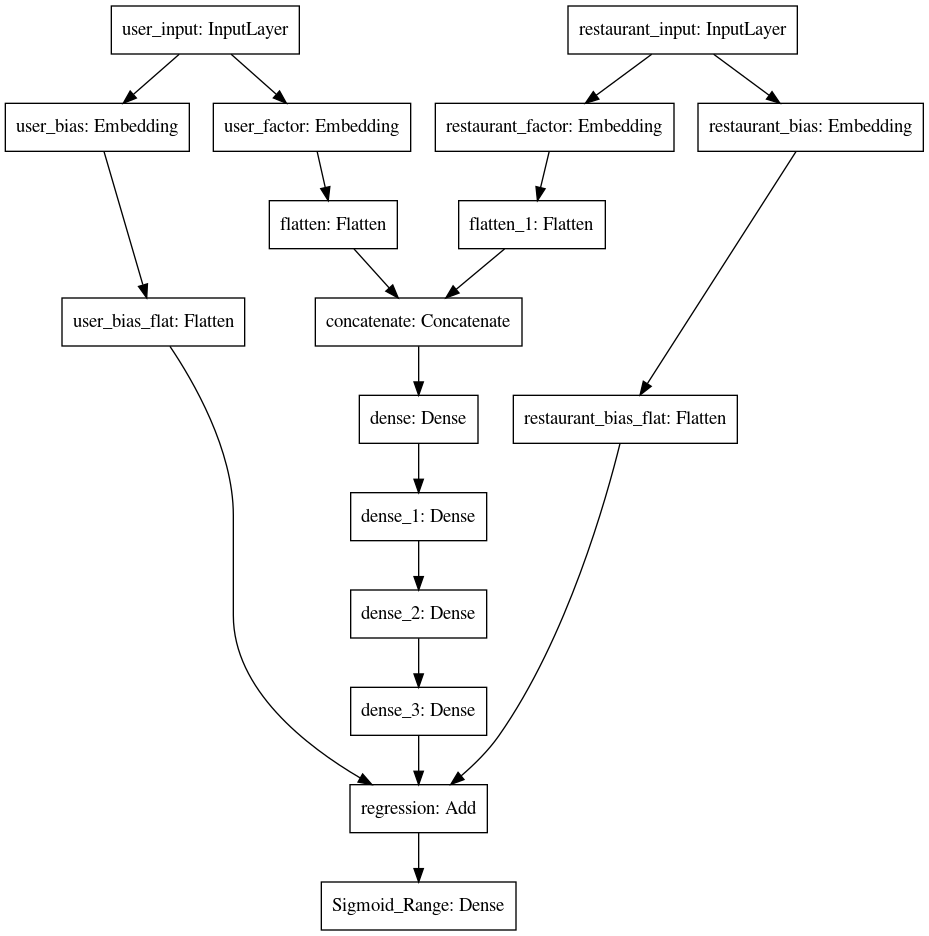

In [22]:
plot_model(model2)

In [23]:
#training model
model2.optimizer.learning_rate = 5e-2
h1 = model2.fit([X_train.user_id, X_train.business_id], y_train, epochs=2, 
              validation_data=([X_val.user_id, X_val.business_id], y_val), batch_size=1024)

# model2.optimizer.learning_rate = 5e-3
# h2 = model2.fit([X_train.user_id, X_train.business_id], y_train, epochs=2, 
#               validation_data=([X_val.user_id, X_val.business_id], y_val), batch_size=512)

# model2.optimizer.learning_rate = 1e-4
# h3 = model2.fit([X_train.user_id, X_train.business_id], y_train, epochs=2, 
#               validation_data=([X_val.user_id, X_val.business_id], y_val), batch_size=2048)

Epoch 1/2
4305/4305 [==============================] - 3928s 912ms/step - loss: 12.4924 - val_loss: 4.5020
Epoch 2/2
4305/4305 [==============================] - 3947s 917ms/step - loss: 3.3480 - val_loss: 3.3964


Text(0.5, 1.0, 'loss plot')

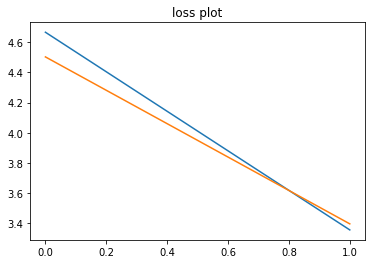

In [24]:
loss = h1.history['loss']#+h2.history['loss']+h3.history['loss']
val_loss = h1.history['val_loss']#+h2.history['val_loss']+h3.history['val_loss']
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.title('loss plot')

In [25]:
model2.save('Nonlinear_Model')

### Deploying Non-Linear Recommendation System 
Here we'll write a function that takes user_id as input and returns personalized recommendations, just like actual websites.

In [26]:
# Getting all the necessary Data
table = make_query("SELECT user_id, business_id, stars FROM reviews")
reviews_df = make_frame(table, ['user_id', 'business_id', 'rating'])

table = make_query("SELECT business_id, name, address, city, state, postal_code, latitude, longitude, stars\
                   FROM businesses")
business_df = make_frame(table, "business_id, name, address, city, state, postal_code, latitude, longitude, stars".split(', '))

del table

Our recommendation system is very large in size we won't put all restaurants at once for one user, this would result in slow recommendation. 

We use candidate generation, which looks at a user's history infers her location, finds best restaurants in her location and also looks at her friends' favourite restaurants. These restaurants are now candidates that user might like.

These candidates now go through our model which ranks them according to predicted rating.

In [46]:
# This cell has candidate generation function

def generate_candidates(user_id, friend=False):
    """
    Returns list of business id's which could be good prospects for a particular user.
    Factors in location and user's friends' choices
    
    Parameters:
    user_id : id of user
    friend : Recursive call to get user's friends. Internal calls only
    
    Return:
    lst : list of restaurant ids. Is not empty
    """
    lst = []
    top_candidates_by_city = 20
    top_candidates_by_frnd = 10

    # By Location
    #all the restaurants user has been to previously
    user_history = reviews_df.query(f'user_id=={user_id}')
    if user_history.shape[0]!=0:
        # Details about those restaurants
        visit_history = business_df.query(f'business_id in {list(user_history.business_id)}')
        # Implying city user lives in by looking at most frequent city in history
        #This will allow our recommendation to personalize recommendations for user
        city_mode = visit_history.city.mode()
        
        if not friend:
            for city in city_mode:
                city_df = business_df.query(f'city == "{city}"').sort_values(by='stars', ascending=False)[:400]
                lst.extend(city_df.business_id[:top_candidates_by_city].values)
        
        #If recursive call return restuarants rated highly by friend
        else:
            frnd_favourite =  visit_history.sort_values(by='stars', ascending=False).business_id.values[:top_candidates_by_frnd]
            lst.extend(frnd_favourite)
            return lst
     
    # Restaurants liked By Friends
    frnd_lst = eval(make_query(f"SELECT friends FROM users WHERE user_id={user_id}")[0][0])

    for frnd in frnd_lst:
        # Recursive Call
        # returns restuarnts friend has been to and has rated highly
        frnd_recom = generate_candidates(frnd, friend=True)
        lst.extend(frnd_recom)
        
    #If list is not empty
    if lst:
        #Return unique entries
        return list(set(lst))
    
    # List is empty Hence user is a loner.
    return loner_user()

def loner_user():
    """
    A user is a loner if he has no friends and has not rated any restaurants. For such users we'll 
    generate candidates based on restaurant base ratings (restaurant biases). 
    This could be a new user on site who hasn't interacted much. 
    
    Return:
    lst : list of restaurant ids. Is not empty
    """
    return_top = 20
    restaurant_bias = model2.get_layer('restaurant_bias').weights[0].numpy()
    bias_df = pd.DataFrame(restaurant_bias, columns=['restaurant_bias'])
    bias_df.index.name='business_id'
    bias_df = bias_df.sort_values(by='restaurant_bias', ascending=False)

    return bias_df.index[:return_top].tolist()

#Improvements 
#Candidate Generation can be improved by adding explicit args for city and restaurant category type

generate_candidates(user_id=4)

[43523,
 30740,
 69145,
 76192,
 69026,
 2981,
 42917,
 30643,
 55732,
 43063,
 9024,
 56129,
 79809,
 42969,
 71513,
 21980,
 29789,
 42080,
 55402,
 11119,
 21884]

In [64]:
# Wrapping our model to simplify use
def recommend(user_id, top=5):
    """
    Uses Recommendation system to recommend restaurant to user.
    
    Parameters:
    user_id : id of user
    top : Number of recommendations [10 by default]
    
    Returns:
    id_lst : List of business ids. List size = top 
    pred_ratings : List of ratings for corresponding business id. List size = top
    """
    
    label = f"predicted_rating_user_id_{user_id}"
    candidates = generate_candidates(user_id=user_id)
    pred_ratings = model2.predict([np.array([user_id]*len(candidates)), np.array(candidates)])
    pred_ratings = np.floor(pred_ratings*2)/2
    pred_df = pd.DataFrame({'business_id':candidates, label:pred_ratings.ravel()})
    df = business_df.query(f'business_id in {candidates}')
    return df.merge(pred_df, on='business_id').sort_values(by=label, ascending=False).head(top)

In [69]:
recommend(user_id=79)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,predicted_rating_user_id_79
0,4224,Murray Hill Foods,4523 Renaissance Pkwy,Cleveland,OH,44128,41.437081,-81.491807,5.0,5.0
28,52036,Lance's Beef,"1979 W 25th St, Ste F-9",Cleveland,OH,44113,41.484690,-81.703063,5.0,5.0
6,15065,Urban Herbs,1979 W25th St,Cleveland,OH,44113,41.484686,-81.703062,5.0,5.0
39,67411,Sangeet Indian Restaurant,2158 S Taylor Rd,Cleveland Heights,OH,44118,41.501095,-81.556400,5.0,5.0
35,62198,Marjees Bar & Grill,3604 Superior Ave,Cleveland,OH,44114,41.512249,-81.665356,5.0,5.0


In [67]:
recommend(user_id=66)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,predicted_rating_user_id_66
6,30740,It's All Good BBQ & More,"321 S Casino Center Blvd, Ste 130",Las Vegas,NV,89101,36.167179,-115.145942,5.0,5.0
0,2981,Vegan Chef Mayra,,Las Vegas,NV,89145,36.168345,-115.265978,5.0,4.5
11,43523,Tacos Y Hot Dogs Sonora,1541 N Eastern Ave,Las Vegas,NV,89101,36.187536,-115.116432,5.0,4.5
18,76192,Cafe Luhena,"4825 W Flamingo Rd, Ste 1",Las Vegas,NV,89103,36.114608,-115.206794,5.0,4.5
17,71513,Dragon Bowl Asian Grill,"6680 W Flamingo Rd, Ste 12",Las Vegas,NV,89103,36.115075,-115.237869,5.0,4.5


### Comparing Models
We'll compare performance of all 3 models : Average, Linear, and Non-linear

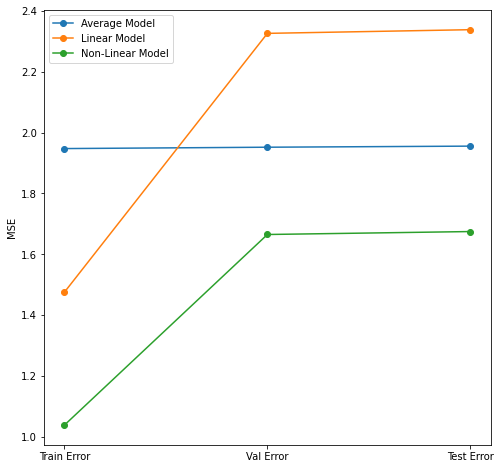

In [31]:
#Calculating MSE 
ticks = ["Train", "Val", "Test"]
avg_model = [train_baseline, val_baseline, test_baseline]
linear_model, non_linear_model = [], []
for data in [(X_train, y_train), (X_val, y_val), (X_test, y_test)]:
    lin_mse = mse(data[1], model.predict([data[0]['user_id'],data[0]['business_id']], verbose=1))
    linear_model.append(lin_mse)
    
    nonlin_mse = mse(data[1], model2.predict([data[0]['user_id'],data[0]['business_id']], verbose=1))
    non_linear_model.append(nonlin_mse)
    
    clear_output()
    
#Plotting Modelwise Error
plt.figure(figsize=(8,8))
ax = plt.gca()

ax.plot(avg_model, "o-", label="Average Model")
ax.plot(linear_model, "o-", label="Linear Model")
ax.plot(non_linear_model, "o-", label="Non-Linear Model")

ax.set(xlabel='', ylabel='MSE', xticks=[0,1,2], xticklabels=["Train Error", "Val Error", "Test Error"])
ax.legend()

## Improvements
- Model performance can be improved by further training.
- We can try Denser layers for non-linear combination of embeddings.

## Conclusion
- We made a recommendation system and improved on baseline metrics.
- We recommended new restaurants to users.

#### Links
[1. Getting Data Ready](https://github.com/yashrajwani/Restaurant-Recommendation-System/blob/main/1.%20Getting%20Data%20Ready.ipynb)

[2. Exploratory Data Analysis (EDA)](https://github.com/yashrajwani/Restaurant-Recommendation-System/blob/main/2.%20Exploratory%20Data%20Analysis%20(EDA).ipynb)

Thank You